# COVID-19 शोध पत्रों का विश्लेषण

इस चुनौती में, हम COVID महामारी के विषय पर चर्चा जारी रखेंगे और इस विषय पर वैज्ञानिक शोध पत्रों को प्रोसेस करने पर ध्यान केंद्रित करेंगे। [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) में 7000 से अधिक (इस लेखन के समय) COVID पर शोध पत्र उपलब्ध हैं, जिनमें मेटाडेटा और सारांश शामिल हैं (और लगभग आधे के लिए पूर्ण पाठ भी उपलब्ध है)।

इस डेटासेट का उपयोग करके [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) कॉग्निटिव सेवा का उपयोग करके विश्लेषण करने का एक पूरा उदाहरण [इस ब्लॉग पोस्ट](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) में वर्णित है। हम इस विश्लेषण के एक सरल संस्करण पर चर्चा करेंगे।


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## डेटा प्राप्त करना

सबसे पहले, हमें उन CORD पेपर्स का मेटाडेटा प्राप्त करना होगा जिनके साथ हम काम करेंगे।

**NOTE**: हम इस रिपॉजिटरी के हिस्से के रूप में डेटा सेट की कॉपी प्रदान नहीं करते हैं। आपको पहले [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) फाइल को [Kaggle पर इस डेटा सेट](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) से डाउनलोड करना पड़ सकता है। इसके लिए Kaggle पर रजिस्ट्रेशन की आवश्यकता हो सकती है। आप बिना रजिस्ट्रेशन के [यहां से](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html) भी डेटा सेट डाउनलोड कर सकते हैं, लेकिन इसमें मेटाडेटा फाइल के साथ सभी फुल टेक्स्ट भी शामिल होंगे।

हम ऑनलाइन स्रोत से सीधे डेटा प्राप्त करने की कोशिश करेंगे, लेकिन अगर यह विफल हो जाता है, तो आपको ऊपर बताए गए तरीके से डेटा डाउनलोड करना होगा। साथ ही, अगर आप डेटा के साथ आगे प्रयोग करने की योजना बना रहे हैं, तो इसे डाउनलोड करना समझदारी होगी ताकि प्रतीक्षा समय बच सके।

> **NOTE** कि डेटा सेट काफी बड़ा है, लगभग 1 Gb आकार का, और निम्नलिखित कोड की लाइन को पूरा होने में काफी समय लग सकता है! (~5 मिनट)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

हम अब प्रकाशन तिथि कॉलम को `datetime` में बदलेंगे, और प्रकाशन तिथियों की सीमा देखने के लिए हिस्टोग्राम बनाएंगे।


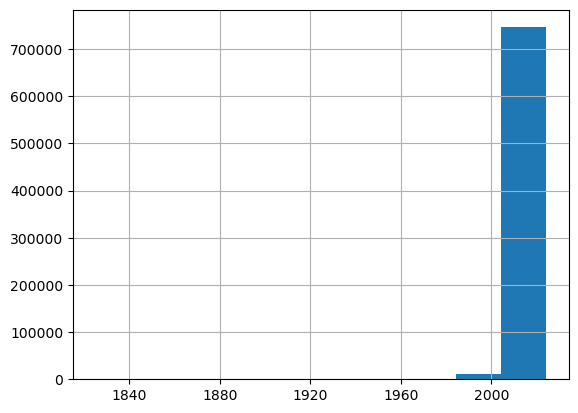

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## संरचित डेटा निष्कर्षण

आइए देखें कि हम सारांशों से किस प्रकार की जानकारी आसानी से निकाल सकते हैं। एक चीज़ जो हमारी रुचि की हो सकती है, वह यह देखना है कि कौन-कौन सी उपचार रणनीतियाँ मौजूद हैं और वे समय के साथ कैसे विकसित हुई हैं। शुरुआत में, हम COVID के इलाज के लिए उपयोग की जाने वाली संभावित दवाओं की सूची और निदानों की सूची मैन्युअल रूप से तैयार कर सकते हैं। इसके बाद, हम इन सूचियों को लेकर शोध पत्रों के सारांश में संबंधित शब्दों को खोज सकते हैं।


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


हमने अपने डेटा फ्रेम में कई कॉलम जोड़े हैं, जो यह दर्शाते हैं कि किसी दिए गए दवा/निदान का सारांश में कितनी बार उल्लेख किया गया है।

> **ध्यान दें** कि जब हम उपस्ट्रिंग की खोज करते हैं, तो हम शब्द की शुरुआत में एक स्पेस जोड़ते हैं। यदि हम ऐसा नहीं करते हैं, तो हमें गलत परिणाम मिल सकते हैं, क्योंकि *chloroquine* को *hydroxychloroquine* के अंदर भी पाया जा सकता है। साथ ही, हम सारांश कॉलम को `str` में बदलने के लिए मजबूर करते हैं ताकि एक त्रुटि से छुटकारा पाया जा सके - `str` को हटाकर देखें कि क्या होता है।

डेटा के साथ काम करना आसान बनाने के लिए, हम केवल दवा गणना वाले सब-फ्रेम को निकाल सकते हैं और घटनाओं की कुल संख्या की गणना कर सकते हैं। इससे हमें सबसे लोकप्रिय दवा मिलती है:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

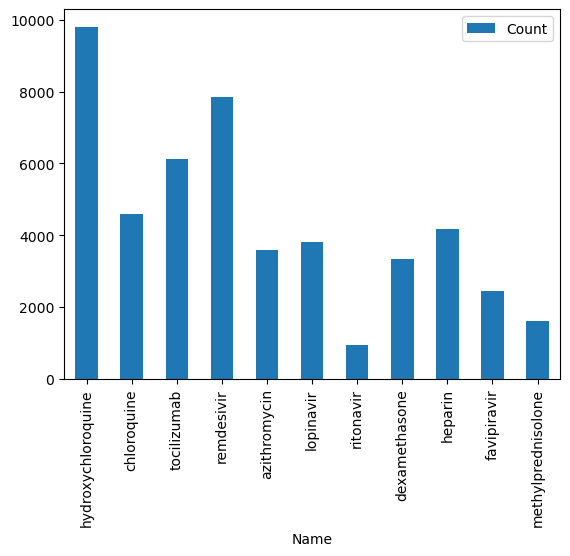

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## उपचार रणनीति में रुझानों की तलाश

उपरोक्त उदाहरण में, हमने सभी मानों का `sum` किया है, लेकिन हम इसे मासिक आधार पर भी कर सकते हैं:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

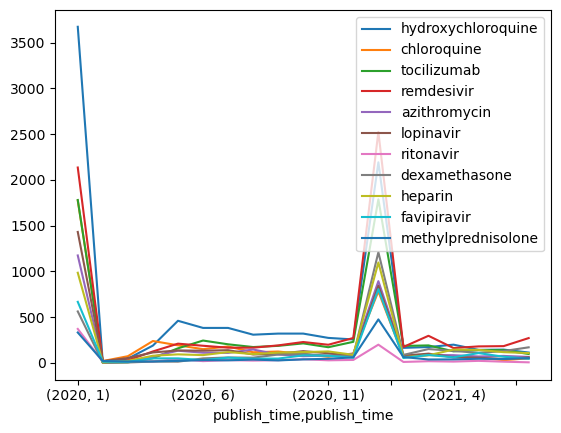

In [152]:
dfmt.plot()
plt.show()

एक दिलचस्प अवलोकन यह है कि हमारे पास दो स्थानों पर बड़े उछाल हैं: जनवरी, 2020 और जनवरी, 2021। इसका कारण यह है कि कुछ शोध पत्रों में प्रकाशन की तारीख स्पष्ट रूप से निर्दिष्ट नहीं होती है, और उन्हें संबंधित वर्ष की जनवरी के रूप में निर्दिष्ट किया जाता है।

डेटा को अधिक समझने योग्य बनाने के लिए, चलिए केवल कुछ दवाओं को विज़ुअलाइज़ करते हैं। हम जनवरी के डेटा को "मिटा" देंगे और इसे कुछ औसत मान से भर देंगे, ताकि ग्राफ़ को अधिक आकर्षक बनाया जा सके:


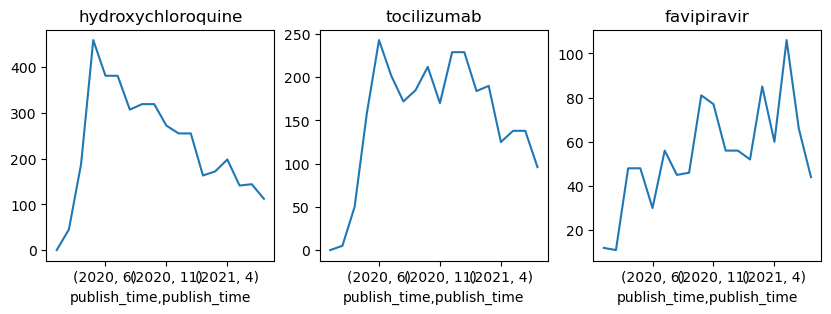

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

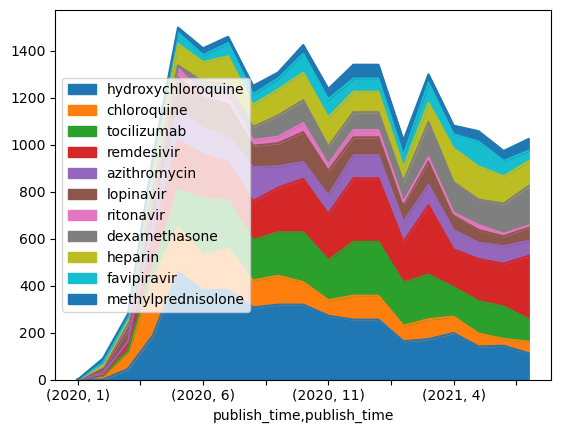

In [154]:
dfmt.plot.area()
plt.show()

यहां तक कि हम प्रतिशत में सापेक्ष लोकप्रियता की गणना भी कर सकते हैं:


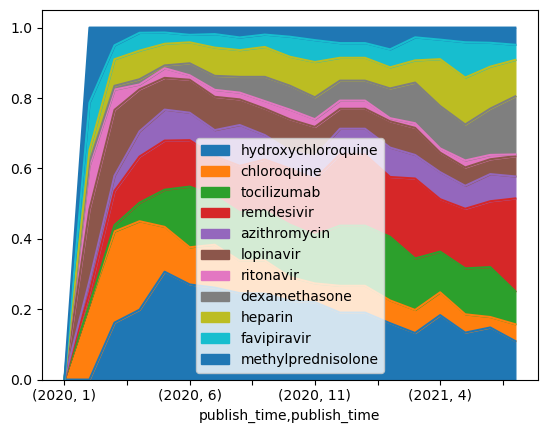

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## चिकित्सा-निदान संगतता की गणना

हम जिन सबसे दिलचस्प संबंधों की तलाश कर सकते हैं, उनमें से एक यह है कि विभिन्न निदानों का इलाज विभिन्न दवाओं से कैसे किया जाता है। इसे देखने के लिए, हमें **सह-अस्तित्व आवृत्ति मानचित्र** की गणना करनी होगी, जो दिखाएगा कि दो शब्द कितनी बार एक ही शोध पत्र में उल्लेखित होते हैं।

इस प्रकार का मानचित्र मूल रूप से एक 2D मैट्रिक्स होता है, जिसे **numpy array** द्वारा सबसे अच्छी तरह से दर्शाया जा सकता है। हम इस मानचित्र की गणना सभी सारांशों के माध्यम से चलते हुए करेंगे और उन संस्थाओं को चिह्नित करेंगे जो वहां मौजूद हैं:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

इस मैट्रिक्स को देखने के तरीकों में से एक है **हीटमैप** बनाना:


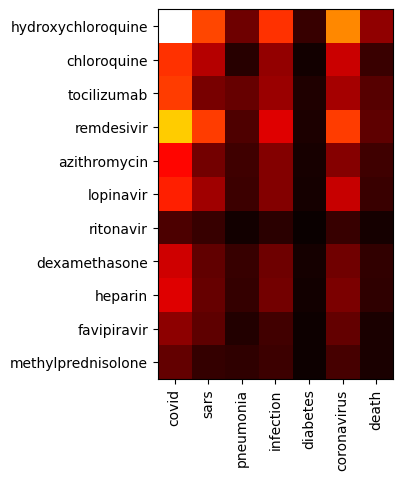

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

हालांकि, **सैंकी** डायग्राम का उपयोग करके और भी बेहतर विज़ुअलाइज़ेशन किया जा सकता है! `matplotlib` में इस प्रकार के डायग्राम के लिए अंतर्निहित समर्थन नहीं है, इसलिए हमें [Plotly](https://plotly.com/python/) का उपयोग करना होगा जैसा कि [इस ट्यूटोरियल](https://plotly.com/python/sankey-diagram/) में बताया गया है।

Plotly सैंकी डायग्राम बनाने के लिए, हमें निम्नलिखित सूचियां बनानी होंगी:
* ग्राफ में सभी नोड्स की सूची `all_nodes`, जिसमें दवाएं और निदान दोनों शामिल होंगे।
* स्रोत और लक्ष्य इंडेक्स की सूची - ये सूचियां दिखाएंगी कि कौन से नोड्स डायग्राम के बाएं भाग में जाते हैं और कौन से दाएं भाग में।
* सभी लिंक की सूची, प्रत्येक लिंक में निम्नलिखित शामिल होंगे:
   - `all_nodes` ऐरे में स्रोत इंडेक्स
   - लक्ष्य इंडेक्स
   - लिंक की ताकत को दर्शाने वाला मान। यह ठीक वही मान है जो हमारी सह-अस्तित्व मैट्रिक्स से आता है।
   - वैकल्पिक रूप से लिंक का रंग। स्पष्टता के लिए कुछ शब्दों को हाइलाइट करने का विकल्प बनाएंगे।

सैंकी डायग्राम को बनाने के लिए सामान्य कोड को एक अलग `sankey` फ़ंक्शन में संरचित किया गया है, जो दो सूचियां (स्रोत और लक्ष्य श्रेणियां) और सह-अस्तित्व मैट्रिक्स लेता है। यह हमें थ्रेशहोल्ड निर्दिष्ट करने की अनुमति भी देता है, और उन सभी लिंक को छोड़ देता है जो उस थ्रेशहोल्ड से कमजोर हैं - इससे डायग्राम थोड़ा कम जटिल हो जाता है।


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## निष्कर्ष

आपने देखा कि हम गैर-संरचित डेटा स्रोतों, जैसे कि टेक्स्ट, से जानकारी निकालने के लिए काफी सरल तरीकों का उपयोग कर सकते हैं। इस उदाहरण में, हमने मौजूदा दवाओं की सूची ली है, लेकिन टेक्स्ट से इकाई निकालने के लिए प्राकृतिक भाषा प्रसंस्करण (NLP) तकनीकों का उपयोग करना कहीं अधिक प्रभावशाली होगा। [इस ब्लॉग पोस्ट](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) में हमने क्लाउड सेवाओं का उपयोग करके इकाई निकालने का तरीका बताया है। एक अन्य विकल्प Python NLP लाइब्रेरी जैसे [NLTK](https://www.nltk.org/) का उपयोग करना होगा - NLTK का उपयोग करके टेक्स्ट से जानकारी निकालने का तरीका [यहां](https://www.nltk.org/book/ch07.html) वर्णित है।


## चुनौती

COVID पेपर डेटा पर निम्नलिखित बिंदुओं के आधार पर शोध जारी रखें:

1. विभिन्न दवाओं का सह-अस्तित्व मैट्रिक्स बनाएं और देखें कि कौन-कौन सी दवाएं अक्सर एक साथ आती हैं (जैसे कि एक ही सारांश में उल्लेखित)। आप दवाओं और निदानों के लिए सह-अस्तित्व मैट्रिक्स बनाने के कोड को संशोधित कर सकते हैं।
1. इस मैट्रिक्स को हीटमैप का उपयोग करके विज़ुअलाइज़ करें।
1. एक अतिरिक्त लक्ष्य के रूप में, आप दवाओं के सह-अस्तित्व को [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram) का उपयोग करके विज़ुअलाइज़ करना चाह सकते हैं। [यह लाइब्रेरी](https://pypi.org/project/chord/) आपको chord diagram बनाने में मदद कर सकती है।
1. एक और अतिरिक्त लक्ष्य के रूप में, विभिन्न दवाओं की खुराक (जैसे **400mg** में *रोजाना 400mg chloroquine लें*) को नियमित अभिव्यक्तियों का उपयोग करके निकालने की कोशिश करें, और एक डेटा फ्रेम बनाएं जो विभिन्न दवाओं के लिए अलग-अलग खुराक दिखाए। **ध्यान दें**: उन संख्यात्मक मानों पर विचार करें जो दवा के नाम के निकट पाठीय क्षेत्र में हैं।



---

**अस्वीकरण**:  
यह दस्तावेज़ AI अनुवाद सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) का उपयोग करके अनुवादित किया गया है। जबकि हम सटीकता सुनिश्चित करने का प्रयास करते हैं, कृपया ध्यान दें कि स्वचालित अनुवाद में त्रुटियां या अशुद्धियां हो सकती हैं। मूल भाषा में उपलब्ध मूल दस्तावेज़ को प्रामाणिक स्रोत माना जाना चाहिए। महत्वपूर्ण जानकारी के लिए, पेशेवर मानव अनुवाद की सिफारिश की जाती है। इस अनुवाद के उपयोग से उत्पन्न किसी भी गलतफहमी या गलत व्याख्या के लिए हम उत्तरदायी नहीं हैं।
